In [3]:
import ee 

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

from geeml.utils import eeprint
import geemap


In [4]:
startDate = ee.Date('2014-10-01')
mtbs = ee.FeatureCollection("USFS/GTAC/MTBS/burned_area_boundaries/v1")\
    .filter(ee.Filter.gte('Ig_Date', startDate.millis()))
mtbs_sz = 7583#mtbs.size().getInfo()
mtbs_list = mtbs.toList(mtbs_sz)

In [5]:
mtbs_sz

7583

In [6]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
for fire in range(5,6):
    event = ee.Feature(mtbs_list.get(fire))
    startDate = ee.Date(event.getNumber('Ig_Date'))
    endDate = startDate.advance(6, 'week')
    sat_data = ee.ImageCollection('COPERNICUS/S1_GRD')
    img = sat_data.filterBounds(event.geometry()).filterDate(startDate, endDate).sort('system:time_start', True)
    print(ee.Date(img.first().date()).format().getInfo())
    Map.addLayer(img.first().select('SR_B.').multiply(0.0000275).add(-0.2), {'min':0, 'max':0.7, 'bands': ['SR_B7', 'SR_B5', 'SR_B4']})
    Map.addLayer(event.geometry())
    Map.centerObject(event.geometry(), 8)
    # eeprint(img)

In [11]:
# Given a fire event get pre and post fire image from single sensor 
eventDate = ee.Date(event.getNumber('Ig_Date'))
print('event Date:', eventDate.format().getInfo())
dateBuffer = 4
# get first image after fire
startDate = eventDate
endDate = eventDate.advance(dateBuffer, 'week')
sat_data = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
postFireImg = sat_data.filterBounds(event.geometry()).filterDate(startDate, endDate).sort('system:time_start', True).first()
print('postFire Date:', ee.Date(postFireImg.date()).format().getInfo())

# get first image before fire
startDate = eventDate.advance(dateBuffer*-1, 'week')
endDate = eventDate
preFireImg = sat_data.filterBounds(event.geometry()).filterDate(startDate, endDate).sort('system:time_start', False).first()
print('preFire Date:', ee.Date(preFireImg.date()).format().getInfo())

# Visualise images
Map.addLayer(postFireImg.select('SR_B.').multiply(0.0000275).add(-0.2), {'min':0, 'max':0.7, 'bands': ['SR_B7', 'SR_B5', 'SR_B4']}, 'Post')
Map.addLayer(preFireImg.select('SR_B.').multiply(0.0000275).add(-0.2), {'min':0, 'max':0.7, 'bands': ['SR_B7', 'SR_B5', 'SR_B4']}, 'Pre')

Map.addLayer(event.geometry())
Map.centerObject(event.geometry(), 8)

event Date: 2017-07-30T07:00:00
postFire Date: 2017-08-05T18:19:45
preFire Date: 2017-07-29T18:13:31


In [12]:
supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

In [7]:
import sys
from typing import Union
from geedim.download import BaseImage
from pathlib import Path
from tqdm.auto import tqdm

MODULE_FULL_PATH = r'C:\Users\coach\myfiles\python_modules'

sys.path.insert(1, MODULE_FULL_PATH)
import wrapper as wp #https://github.com/adugnag/gee_s1_ard

### Citation
# Mullissa, A.; Vollrath, A.; Odongo-Braun, C.; Slagter, B.; Balling, J.; Gou, Y.; Gorelick, N.;
# Reiche, J. Sentinel-1 SAR Backscatter Analysis Ready Data Preparation in Google Earth Engine.
# Remote Sens. 2021, 13, 1954. https://doi.org/10.3390/rs13101954

parameters = {#1. Data Selection
              'START_DATE': "2020-01-01",
              'STOP_DATE': "2020-03-31",
              'POLARIZATION':'VVVH',
              'PLATFORM_NUMBER': ['A','B'],
              'ORBIT' : 'BOTH',
              'ORBIT_NUM': None,
              'ROI': None, 
              #2. Additional Border noise correction
              'APPLY_BORDER_NOISE_CORRECTION': True,
              #3.Speckle filter
              'APPLY_SPECKLE_FILTERING': True,
              'SPECKLE_FILTER_FRAMEWORK': 'MONO',
              'SPECKLE_FILTER': 'REFINED LEE',
              'SPECKLE_FILTER_KERNEL_SIZE': 9,
              'SPECKLE_FILTER_NR_OF_IMAGES': 10,
              #4. Radiometric terrain normalization
              'APPLY_TERRAIN_FLATTENING': True,
              'DEM': ee.ImageCollection("projects/sat-io/open-datasets/GLO-30").mosaic(),
              'TERRAIN_FLATTENING_MODEL': 'VOLUME',
              'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER': 0,
              #5. Output
              'FORMAT' : 'DB',
              'CLIP_TO_ROI': False,
              'SAVE_ASSET': False,
              'ASSET_ID':None}

In [10]:
# Given a fire event get pre and post fire image from multi-sensors
def getOpticalRadarPairs(event: ee.Feature, dateBuffer: int = 4)-> Union[ee.Image, ee.Image, ee.Image, ee.Image]:
    """
    Get the temporally closest pre-fire and post-fire radar and optical image pairs after preprocessing both
     the radar and optical images.

    Args:
        event (ee.Feature): A fire event delineating the boundary of burnt area
        dateBuffer (int): The temporal window to locate a relevant image. In units of weeks.

    Returns:
        Four images, a pre-fire and post-fire optical-radar image pair
    """
    eventDate = ee.Date(event.getNumber('Ig_Date'))
    # postfire
    startDate = eventDate
    endDate = eventDate.advance(dateBuffer, 'week')
    s1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(event.geometry())
    s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(event.geometry())
    l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(event.geometry())
    l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(event.geometry())
    s2post = s2.filterDate(startDate, endDate).sort('system:time_start', True).first()
    l8post = l8.filterDate(startDate, endDate).sort('system:time_start', True).first()
    l9post = l9.filterDate(startDate, endDate).sort('system:time_start', True).first()
    # get the earliest optical image (between L8, L9 and S2) that was captured after the fire event
    postOpticalImage = ee.ImageCollection.fromImages([s2post, l8post, l9post]).sort('system:time_start', True).first()
    # pre-process post-fire image
    postOpticalImage = preprocessOptical(postOpticalImage)
    
    # RADAR
    s1post = s1.filterDate(startDate, endDate).sort('system:time_start', True).first()
    # preprocess pre-fire radar image
    parameters.update({'STOP_DATE': s1post.date().advance(1, 'day'), 'START_DATE': s1post.date(), 'ROI': event.geometry()})
    s1post = wp.s1_preproc(parameters).select('V.')
    
    # pre-fire
    startDate = eventDate.advance(dateBuffer*-1, 'week')
    endDate = eventDate
    s2pre = s2.filterDate(startDate, endDate).sort('system:time_start', False).first()
    l8pre = l8.filterDate(startDate, endDate).sort('system:time_start', False).first()
    l9pre = l9.filterDate(startDate, endDate).sort('system:time_start', False).first()
    # get the optical image (between L8, L9 and S2) that was captured before the fire event
    preOpticalImage = ee.ImageCollection.fromImages([s2pre, l8pre, l9pre]).sort('system:time_start', True).first()
    # pre-process post-fire image
    preOpticalImage = preprocessOptical(preOpticalImage)

    #RADAR
    s1pre = s1.filterDate(startDate, endDate).sort('system:time_start', False).first()
    # preprocess post-fire radar image
    parameters.update({'STOP_DATE': s1pre.date().advance(1, 'day'), 'START_DATE': s1pre.date(), 'ROI': event.geometry()})
    s1pre = wp.s1_preproc(parameters).select('V.')
    return preOpticalImage.regexpRename('$', '_pre'), s1pre, postOpticalImage.regexpRename('$', '_post'), s1post

def preprocessOptical(image):
    # Get optical sensor name
    sensor = image.get('SPACECRAFT_ID').getInfo()
    if sensor is None:
        sensor = 'Sentinel-2'
    # Step 1) select useful bands
    bandSelect = {'Sentinel-2': 'B.*',
                    'LANDSAT_8': 'SR_B.',
                    'LANDSAT_9': 'SR_B.'}
    # Step 2) radiometric correction
    radiometricMultiplySelect = {'Sentinel-2': 0.0001,
                    'LANDSAT_8': 0.0000275,
                    'LANDSAT_9': 0.0000275}
    radiometricAddSelect = {'Sentinel-2': 0,
                    'LANDSAT_8': -0.2,
                    'LANDSAT_9': -0.2}
    
    # Step 3) depending on image selected, select cloud band
    return image.select(bandSelect.get(sensor)).multiply(radiometricMultiplySelect.get(sensor)).add(radiometricAddSelect.get(sensor))

In [ ]:
def prepareLabel(event: ee.Feature, patchSize: int, scale: int)-> ee.Image:
    """
    Converts a burn area polygon (ee.Feature) to a raster label. Burnt pixels are assigned a value of 1.
    Unburnt pixels are assigned a value of 0. the returned ee.Image dimensions should closely approximate
    the number of pixels divisible by the patchSize.

    Args:
        event(ee.Feature): The delineated burn area polygon to rasterize.
        patchSize (int): The desirable patch dimension when training the DNN model.
        scale (int): The desired output scale for the label.

    Returns:
        The rasterised label (ee.Image)
    """
    # Define the WKT string for EPSG:102005
    wkt = ('PROJCS["USA_Contiguous_Equidistant_Conic",'
        'GEOGCS["GCS_North_American_1983",'
        'DATUM["D_North_American_1983",'
        'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
        'PRIMEM["Greenwich",0.0],'
        'UNIT["Degree",0.0174532925199433]],'
        'PROJECTION["Equidistant_Conic"],'
        'PARAMETER["False_Easting",0.0],'
        'PARAMETER["False_Northing",0.0],'
        'PARAMETER["longitude_of_center",-96.0],'
        'PARAMETER["Standard_Parallel_1",33.0],'
        'PARAMETER["Standard_Parallel_2",45.0],'
        'PARAMETER["latitude_of_center",39.0],'
        'UNIT["Meter",1.0]]')

    # Create the ee.Projection object
    projection = ee.Projection(wkt)
    
    # Create a covering grid using the equal-distance projection. each cell is 1 patch
    covering_grid = event.geometry().coveringGrid(projection, patchSize*scale).geometry().bounds(scale*0.9)
    
    # Return binary label, 1= burn pixels, 0 = unburnt pixels
    extent = ee.Image.constant(1).clip(covering_grid)
    burnt = ee.Image.constant(1).clip(event.geometry())
        
    label = extent.updateMask(burnt).unmask(0)
    return label.rename('label')


def downloadInstance(event, dateBuffer, patchSize, scale, id):
    preOpt, s1pre, postOpt, s1post = getOpticalRadarPairs(event, dateBuffer)

    label = prepareLabel(event, patchSize, scale)
    eventInstance =  preOpt.addBands([s1pre.mosaic().regexpRename('$', '_pre'), postOpt, ee.Image(s1post.mosaic().regexpRename('$', '_post'))])
    xfilename = Path(f"C:/Users/coach/myfiles/postdoc/Fire/data/DNN/X/image_{id}.tif")
    BaseImage(eventInstance).download(xfilename, crs='EPSG:4326', region= label.geometry(), scale= 30, overwrite=True, num_threads=20)
    yfilename = Path(f"C:/Users/coach/myfiles/postdoc/Fire/data/DNN/Y/label_{id}.tif")
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= 30, overwrite=True, num_threads=20)
    
for id in tqdm(range(0, 5)):#mtbs_sz
    fire = ee.Feature(mtbs_list.get(id))
    downloadInstance(fire, 4, 256, 30, id)

In [66]:
from pathlib import Path
from torchgeo.datasets import RasterDataset, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torch.utils.data import DataLoader
from torchgeo.transforms import AugmentationSequential
from torchgeo.transforms import indices

root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN")
assert root.exists()

train_imgs = RasterDataset(paths=(root/'X').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'Y').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False

flipnslide = FlipnSlideAug(tilesize=64, viz=True)
tfms = AugmentationSequential(flipnslide,
    data_keys = ["image"]
)

train_dset = train_imgs & train_msks

train_sampler = RandomGeoSampler(train_imgs, size=256, length=158, units=Units.PIXELS)

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=1, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
train_batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

torch.Size([1, 14, 256, 256])


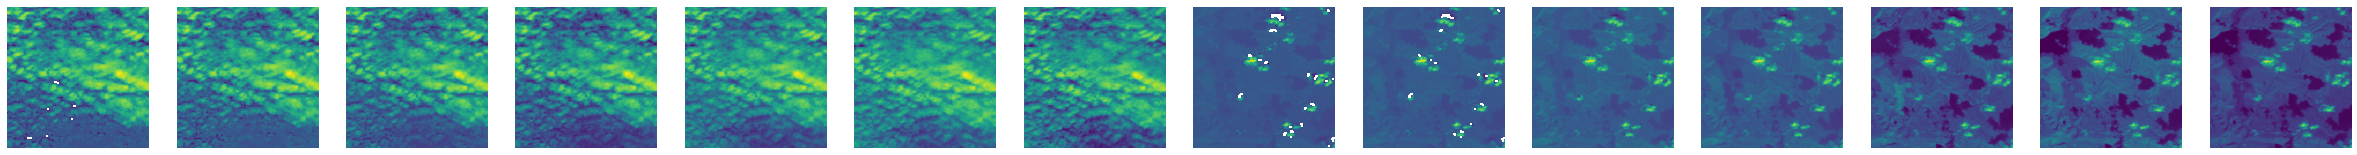

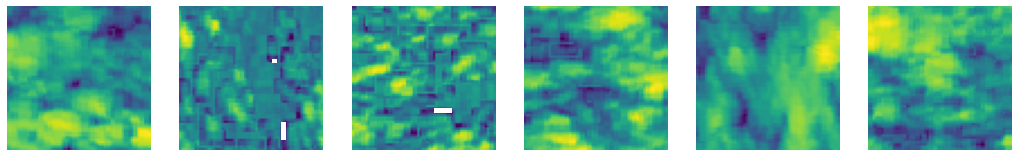

torch.Size([58, 14, 64, 64])


In [67]:
print(train_batch['image'].shape)
print(tfms(train_batch)['image'].shape)


In [53]:
import torch 
class FlipnSlideAug(torch.nn.Module):
    def __init__(self, tilesize: int, viz: bool = False):
        super().__init__()

        self.tilesize = tilesize
        self.viz = viz

    def forward(self, inputs: dict):

        sample_tiled = FlipnSlide(tile_size=self.tilesize, data_type='tensor',
                          save=False, image= inputs.squeeze().numpy(), viz = self.viz)

        return sample_tiled.tiles


In [47]:
#Once data is extracted, perform flipnslide
from flipnslide.tiling import FlipnSlide
import rasterio as rio

In [22]:
timg = rio.open(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X\image_0.tif")
timg.shape

(313, 763)

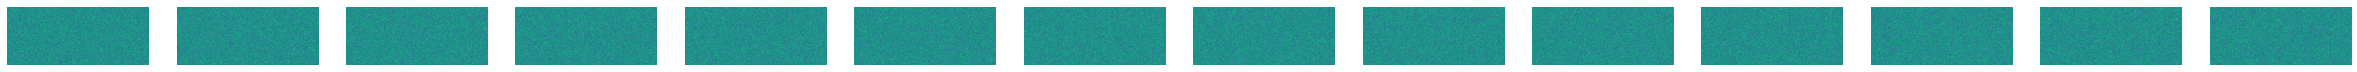

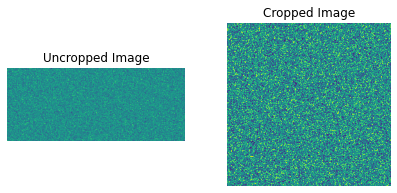

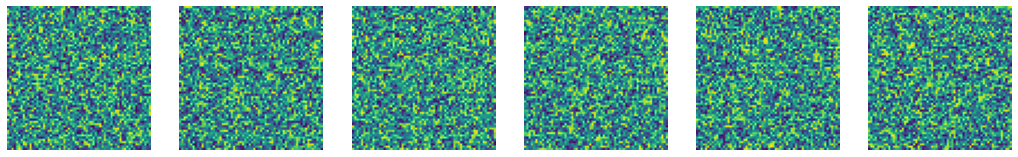

In [48]:
import numpy as np
sample_image = np.random.rand(14, 313, 763)
sample_tiled = FlipnSlide(tile_size=64, data_type='tensor',
                          save=False, image=sample_image, viz = True)

In [25]:
tiles = sample_tiled.tiles

In [26]:
tiles.shape

torch.Size([58, 3, 64, 64])

In [39]:
year = startDate.get('year').getInfo()
timelapse = geemap.landsat_timelapse(
    event.geometry().bounds(),
    out_gif='landsat.gif',
    start_year= year,
    end_year= year,
    start_date='10-07',
    end_date='12-30',
    frequency='month',
    bands=['SWIR2','NIR', 'Red'],#nir, swir2, gr
    frames_per_second=1,
    title='Landsat-8 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\notebooks\landsat.gif


Output()

In [28]:
timelapse = geemap.sentinel2_timelapse(
    event.geometry().bounds(),
    out_gif='sentinel2.gif',
    start_year= year,
    end_year= year,
    start_date='05-01',
    end_date='06-30',
    frequency='week',
    bands=['SWIR2','NIR', 'Red'],#nir, swir2, gr
    frames_per_second=1,
    title='Sentinel-2 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\notebooks\sentinel2.gif


Output()